## Make polygon features from specified raster cells
In this example, we have some MODFLOW input files, including a BAS file, and want to make a polygon of the active area where streams will be simulated.  
* We want the polygon to encompass the union of the active part of the IBOUND array in layer 1 that is on land (not in the Gulf of Mexico).  
* In this case, we are starting with a numpy array that was read in by flopy, but we could just as easily start with a raster by using rasterio to read it in first.

In [1]:
import sys
sys.path.append('D:/ATLData/Documents/GitHub/flopy/')
import numpy as np
import pandas as pd
import rasterio
from rasterio import features
from shapely.geometry import shape
from shapely.affinity import rotate, translate, scale
import flopy
from flopy.utils.reference import SpatialReference
import matplotlib.pyplot as plt
from GISio import df2shp

% matplotlib inline

#### model location and grid information

In [2]:
fm = flopy.modflow
model_ws = '3-Input/A-calibration'

xll, yll = -244389.35, 248497.84
epsg = 5070 # apparently not on spatialreference.org
rot = 20.
dxdy = 5280
dxdy_m = 5280*.3048
dxdy_m

1609.344

#### load the model using `flopy`

In [3]:
m = fm.Modflow.load('clas.nam', model_ws=model_ws)

In [4]:
m.sr = SpatialReference(delc=m.dis.delc, delr=m.dis.delr,
                        xll=xll, yll=yll, rotation=rot,
                        length_multiplier=0.3048)

### plot the ibound array in layer 1

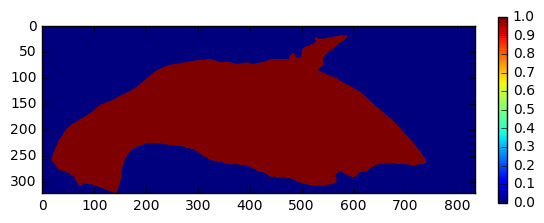

In [5]:
plt.imshow(m.bas6.ibound.array[0])
plt.colorbar(fraction=.02)

### plot model top

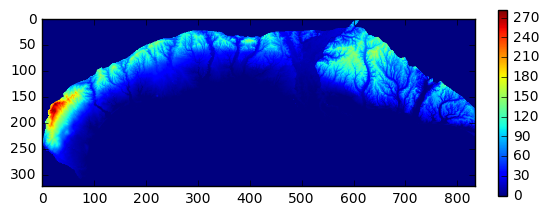

In [6]:
plt.imshow(m.dis.top.array, vmin=0)
plt.colorbar(fraction=.02)

### make a mask

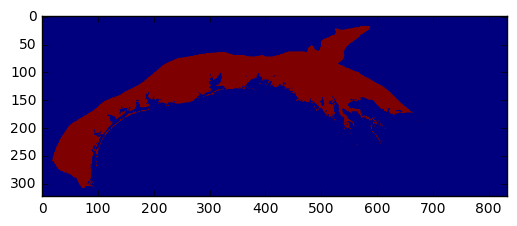

In [7]:
mask = (m.bas6.ibound[0].array ==1) & (m.dis.top.array > 0)

plt.imshow(mask)

### make the shapes
this returns a GeoJSON-type mapping of every contiguous group of pixels in the mask

In [8]:
shapes = features.shapes(np.ones((m.nrow, m.ncol), dtype=int), mask=mask)
shapes = list(shapes)
shapes = [shape(s[0]) for s in shapes] # convert to shapely features
areas = [s.area for s in shapes]
df = pd.DataFrame({'area': areas, 'geometry': shapes})

#### find the largest shape and retain that one 

In [9]:
df.sort_values(by='area', ascending=False, inplace=True)
df.head()

,area,geometry
129,41840.0,"POLYGON ((577 19, 577 20, 576 20, 569 20, 569 ..."
118,73.0,"POLYGON ((101 236, 101 238, 100 238, 99 238, 9..."
44,62.0,"POLYGON ((163 172, 163 173, 164 173, 164 174, ..."
89,43.0,"POLYGON ((126 198, 126 199, 125 199, 125 200, ..."
39,32.0,"POLYGON ((191 166, 191 167, 190 167, 190 168, ..."


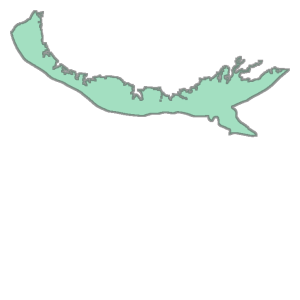

In [10]:
# a zero-width buffer can be used to "clean up" any self-intersections 
#that might have resulted from vectorization of raster pixels
stream_domain = df.geometry.values[0].buffer(0)
stream_domain

### No information about location was conveyed by the numpy array so we have to transform the coordinates before writing the shapefile
(note that the above plot is upside down, because the coordinates are relative to the matrix origin (upper left corner))  
* We can do this using the `affinity` module in shapely
* The upper left corner can be obtained from the model spatial reference

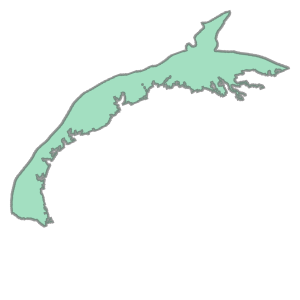

In [11]:
stream_domain_tr = scale(stream_domain, dxdy_m, -dxdy_m, origin=(0,0))
stream_domain_tr = rotate(stream_domain_tr, 20, origin=(0,0))
stream_domain_tr = translate(stream_domain_tr, m.sr.xul, m.sr.yul)
stream_domain_tr

#### write the shapefile

In [12]:
df2shp(pd.DataFrame([{'geometry': stream_domain_tr}]), 'shps/stream_domain.shp', epsg=epsg)

writing shps/stream_domain.shp...
